# Assignment 3 - Design and Implementation of 3D Graphics Systems - IMPA 2021

# Absolute camera orientation given set of relative camera pairs

The problem we deal with is defined as follows:

Given an optical system of $N$ cameras with extrinsics $\{g_1, ..., g_N | g_i \in SE(3)\}$, and a set of relative camera positions $\{g_{ij} | g_{ij}\in SE(3)\}$ that map between coordinate frames of randomly selected pairs of cameras $(i, j)$, we search for the absolute extrinsic parameters $\{g_1, ..., g_N\}$ that are consistent with the relative camera motions.

More formally:
$$
g_1, ..., g_N = 
{\arg \min}_{g_1, ..., g_N} \sum_{g_{ij}} d(g_{ij}, g_i^{-1} g_j),
$$,
where $d(g_i, g_j)$ is a suitable metric that compares the extrinsics of cameras $g_i$ and $g_j$. 

Visually, the problem can be described as follows. The picture below depicts the situation at the beginning of our optimization. The ground truth cameras are plotted in purple while the randomly initialized estimated cameras are plotted in orange:
![Initialization](https://github.com/facebookresearch/pytorch3d/blob/master/docs/tutorials/data/bundle_adjustment_initialization.png?raw=1)

Our optimization seeks to align the estimated (orange) cameras with the ground truth (purple) cameras, by minimizing the discrepancies between pairs of relative cameras. Thus, the solution to the problem should look as follows:
![Solution](https://github.com/facebookresearch/pytorch3d/blob/master/docs/tutorials/data/bundle_adjustment_final.png?raw=1)

In practice, the camera extrinsics $g_{ij}$ and $g_i$ are represented using objects from the `PerspectiveCameras` class initialized with the corresponding rotation and translation matrices `R_absolute` and `T_absolute` that define the extrinsic parameters $g = (R, T); R \in SO(3); T \in \mathbb{R}^3$. In order to ensure that `R_absolute` is a valid rotation matrix, we represent it using an exponential map (implemented with `so3_exponential_map`) of the axis-angle representation of the rotation `log_R_absolute`.


## 0. Install and Import Modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.7") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    541      0 --:--:-- --:--:-- --:--:--   541
100  404k    0  404k    0     0   864k      0 --:--:-- --:--:-- --:--:--  864k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-5exx3sov
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-5exx3sov
  Running command git checkout -q 3c15a6c2469249c8b90a4f3e41e34350b8051b92
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 645kB 10.9MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.4.0-cp37-cp37m-linux_x86_64.whl size=23225102 sha256=e09ca17308fcb0c0b34ba80a2b08b790bebb3574b5629191374252aa8f746f3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5buqiw3v/wheels/89/69/08/d864f516508b5d943259c6088baa150eb

In [ ]:
# imports
import matplotlib.pyplot as plt
import torch
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
from pytorch3d.renderer.cameras import (
    PerspectiveCameras,
)

from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    RasterizationSettings, PointLights, MeshRenderer, 
    MeshRasterizer, SoftPhongShader
)

# add path for demo utils
import sys
import os
sys.path.append(os.path.abspath(''))

# set for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

If using **Google Colab**, fetch the utils file for plotting the camera scene, and the ground truth camera positions:

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/camera_visualization.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from camera_visualization import plot_camera_scene
from plot_image_grid import image_grid

!mkdir data
!wget -P data https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/data/camera_graph.pth

--2021-05-29 18:56:47--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/camera_visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1893 (1.8K) [text/plain]
Saving to: ‘camera_visualization.py’

camera_visualizatio 100%[===================>]   1.85K  --.-KB/s    in 0s      

2021-05-29 18:56:48 (34.2 MB/s) - ‘camera_visualization.py’ saved [1893/1893]

--2021-05-29 18:56:48--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
H

OR if running **locally** uncomment and run the following cell:

In [ ]:
# from utils import plot_camera_scene
# from utils import image_grid

## 1. Set up Cameras and load ground truth positions

In [ ]:
# load the SE3 graph of relative/absolute camera positions
camera_graph_file = './data/camera_graph.pth'
(R_absolute_gt, T_absolute_gt), \
    (R_relative, T_relative), \
    relative_edges = \
        torch.load(camera_graph_file)
#relative edges are 190, 20*20 matrix upper - diagonal, 1 edge between each camera

# create the relative cameras
cameras_relative = PerspectiveCameras(
    R = R_relative.to(device),
    T = T_relative.to(device),
    device = device,
)

# create the absolute ground truth cameras
cameras_absolute_gt = PerspectiveCameras(
    R = R_absolute_gt.to(device),
    T = T_absolute_gt.to(device),
    device = device,
)

# the number of absolute camera positions
N = R_absolute_gt.shape[0]

1.1 Check the ground truth values for rotation and translation of the first camera $g_0$. Do they look like measured values or arbitrary ones? Why do you think this decision was taken?

É um valor arbitrário, pois se assume que g0 dita o sistema de coordenadas do problema sendo otimizado.

O processo de otimização busca minimizar a "distância" entre cada par de câmeras a partir das câmeras relativas. Nesse caso, a matriz da câmera relativa se refere a matriz essencial, que faz o mapeamento de uma câmera para outra. 

No caso da g0, pode-se assumir que os parâmetros intrínsicos e extrínsicos dessa câmera são conhecidos através de um processo de calibração. A partir disso, a primeira camera define um sistema de coordenadas, no final das contas. Usando essa solução, é possível achar uma solução justamente minimizando a discrepância entre cada par de câmeras, tenho a câmera g0 como âncora. Isso seria uma forma de simplificar o problema já que existe esse referencial definido pela câmera g0. Isso também pode ser definida como uma etapa de normalização. Vale ressaltar que nesse caso, assumimos que todas as câmeras possuem os mesmos parâmetros intrínsicos.

Essa solução tem como base todos os conceitos definidos na geometria epipolar, que define a solução de mapeamento entre duas cameras. Nesse caso, o interessado é justamente calcular a transformação relativa entre cada par de câmeras.

Caso isso não seja feito, não é possível achar uma solução para este problema. Uma coisa que fiz nesse caso foi rodar a função de otimização sem aplicar a máscara, e vi que ao final as câmeras respeitaram a distância, mas justamente em posições diferentes, como se estivessem em um outro sistema de coordenadas.

In [ ]:
print(T_absolute_gt[0])
print(R_absolute_gt[0])

tensor([-0., -0., -0.])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


## 2. Define optimization functions

### Relative cameras and camera distance
We now define two functions crucial for the optimization.

**`calc_camera_distance`** compares a pair of cameras. This function is important as it defines the loss that we are minimizing. The method utilizes the `so3_relative_angle` function from the SO3 API.

**`get_relative_camera`** computes the parameters of a relative camera that maps between a pair of absolute cameras. Here we utilize the `compose` and `inverse` class methods from the PyTorch3D Transforms API.

In [ ]:
def calc_camera_distance(cam_1, cam_2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between 
    the rotation components of the camera extrinsics and the L2 distance
    between the translation vectors.
    """
    # rotation distance
    R_distance = (1.-so3_relative_angle(cam_1.R, cam_2.R, cos_angle=True)).mean()
    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance

def get_relative_camera(cams, edges):
    """
    For each pair of indices (i,j) in "edges" generate a camera
    that maps from the coordinates of the camera cams[i] to 
    the coordinates of the camera cams[j]
    """

    # first generate the world-to-view Transform3d objects of each 
    # camera pair (i, j) according to the edges argument
    trans_i, trans_j = [
        PerspectiveCameras(
            R = cams.R[edges[:, i]],
            T = cams.T[edges[:, i]],
            device = device,
        ).get_world_to_view_transform()
         for i in (0, 1)
    ]
    
    # compose the relative transformation as g_i^{-1} g_j
    trans_rel = trans_i.inverse().compose(trans_j)
    
    # generate a camera from the relative transform
    matrix_rel = trans_rel.get_matrix()
    cams_relative = PerspectiveCameras(
                        R = matrix_rel[:, :3, :3],
                        T = matrix_rel[:, 3, :3],
                        device = device,
                    )
    return cams_relative

2.1 In this task, we are parameterizing the 3D rotation group - $SO(3)$ - using rotation matrices. This choice has some drawbacks, as we need to ensure our matrices are valid rotation matrices. Which other choice(s) could we have used to parameterize rotations? Would it be a better choice?

Existem diferentes formas de parametrizar a matriz de rotação da camera:

1. Fixed/Euler angles: Nessa representação, definem-se 3 ângulos, que calculam as matrizes de rotação. Essas rotações podem ser aplicadas em diferentes ordens usando um sistema de eixos global ou local.

Esse modelo tem um problema de singularidade, definindo o gimbal lock. Além disso, a interpolação acaba sendo difícil quando é feita por eixos diferentes.

Um dos aspectos desse tipo de representação é que a ordem importa. Nesse caso, dependendo da ordem, o resultado acaba sendo diferente.

Um dos problemas também é que uma leve mudança dos parâmetros não representa a mesma rotação de um modelo. Exemplo: rotação perto do pólo da terra.

2. Axis angle: Nesse caso, a rotação é calculada através de um eixo arbitrário. Usualmente calculado utilizando a Rodriguez Formula. De acordo com a documentação, essa é a implementação feita no pytorch 3D usando o  so3_exponential_map.

Essa representação acaba não gerando mais o problema de gimbal lock. No entanto, para compor uma rotação, é necessário transformar de volta para matriz.

Possui ambiguidade caso o eixo negativo seja usado. Além disso, a interpolação entre dois eixos e ângulos diferentes pode não ser tão suave. Interpolação em apenas um eixo é suave.

Assim como em ângulos de euler, se é aplicada uma breve mudança nos parâmetros, a rotação no modelo não é consistente, não apresenta uma "uniformidade".

Diferença entre duas rotações pode ser difícil de ser interpretada, principalmente nas bordas (onde eu perco a continuidade).
https://www.ccs.neu.edu/home/rplatt/cs5335_fall2017/slides/euler_quaternions.pdf
Nesse caso, pode ser resolvido através da transformação desse vetor em uma matriz.

3. Quaternion: Melhor forma de interpolação entre um ponto e outro, o que pode gerar uma variação mais suave (esfera unitária em 4D). No entanto, é necessário manter o quatérnion em tamanho unitário.

Possui uma representação relativamente mais compacta, sempre mantendo 4 números ao invés de precisar tranformar na matriz.

Assim como em métodos de euler, a ordem importa, e gera resultados diferentes. No entanto, nesse caso, pequenas mudanças nos parâmetros acaba sendo mais consistente com a rotação aplicada no corpo rígido.

Por fim, em termos de probabilidade, a geração de quaternions aleatórios acaba gerando uma distribuição mais uniforme em uma esfera (Haar measure).

4. 3x3 matrices
– drifting, can’t interpolate


5. SVD: https://arxiv.org/pdf/2006.14616.pdf

## 3. Optimization
Finally, we start the optimization of the absolute cameras.

We use SGD with momentum and optimize over `log_R_absolute` and `T_absolute`. 

As mentioned earlier, `log_R_absolute` is the axis angle representation of the rotation part of our absolute cameras. We can obtain the 3x3 rotation matrix `R_absolute` that corresponds to `log_R_absolute` with:

`R_absolute = so3_exponential_map(log_R_absolute)`


In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
print(device)

cuda:0


iteration=100; camera_distance=5.631e-01
iteration=200; camera_distance=1.121e-01
iteration=300; camera_distance=6.424e-02
iteration=400; camera_distance=4.434e-02
iteration=500; camera_distance=3.181e-02
iteration=600; camera_distance=2.366e-02
iteration=700; camera_distance=1.834e-02
iteration=800; camera_distance=1.479e-02
iteration=900; camera_distance=1.232e-02
iteration=1000; camera_distance=1.055e-02
iteration=1100; camera_distance=9.231e-03
iteration=1200; camera_distance=8.216e-03
iteration=1300; camera_distance=7.416e-03
iteration=1400; camera_distance=6.771e-03
iteration=1500; camera_distance=6.241e-03
iteration=1600; camera_distance=5.800e-03
iteration=1700; camera_distance=5.427e-03
iteration=1800; camera_distance=5.108e-03
iteration=1900; camera_distance=4.834e-03
iteration=1999; camera_distance=4.597e-03


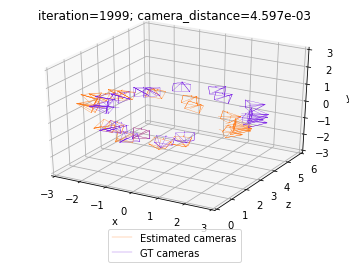

Optimization finished.


In [ ]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one 
# (check exercise 1.1 above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct, 
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.1, momentum=0.9)

losses = {"train loss": []}

# run the optimization
n_iter = 2000  # fix the number of iterations
for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as 
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = so3_exponential_map(log_R_absolute * camera_mask)

    # get the current absolute cameras
    cameras_absolute = PerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # our loss function is the camera_distance
    camera_distance.backward()
    
    # apply the gradients
    optimizer.step()

    # plot and print status message
    if (it % 100==0 or it==n_iter-1) and it != 0:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        print(status)
        losses["train loss"].append(camera_distance)
    if it==n_iter-1:
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

print('Optimization finished.')


3.1. Download the *cow mesh* and user the function `render_scene` (below) to render it using the cameras of the ground truth. Do the same using the initial values of the estimated cameras. 

*You don't need to understand how to set up a renderer now, we'll cover this later on the couser. For now, just focus on analyzing the results.*

In [ ]:
# download the cow mesh
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2021-05-29 18:57:14--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.03s   

2021-05-29 18:57:14 (10.3 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2021-05-29 18:57:14--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=============

In [ ]:
# Load and create cow mesh
from pytorch3d.structures import Meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

obj_file = "data/cow_mesh/cow.obj"
cow_mesh_batch = load_objs_as_meshes([obj_file], device=device)

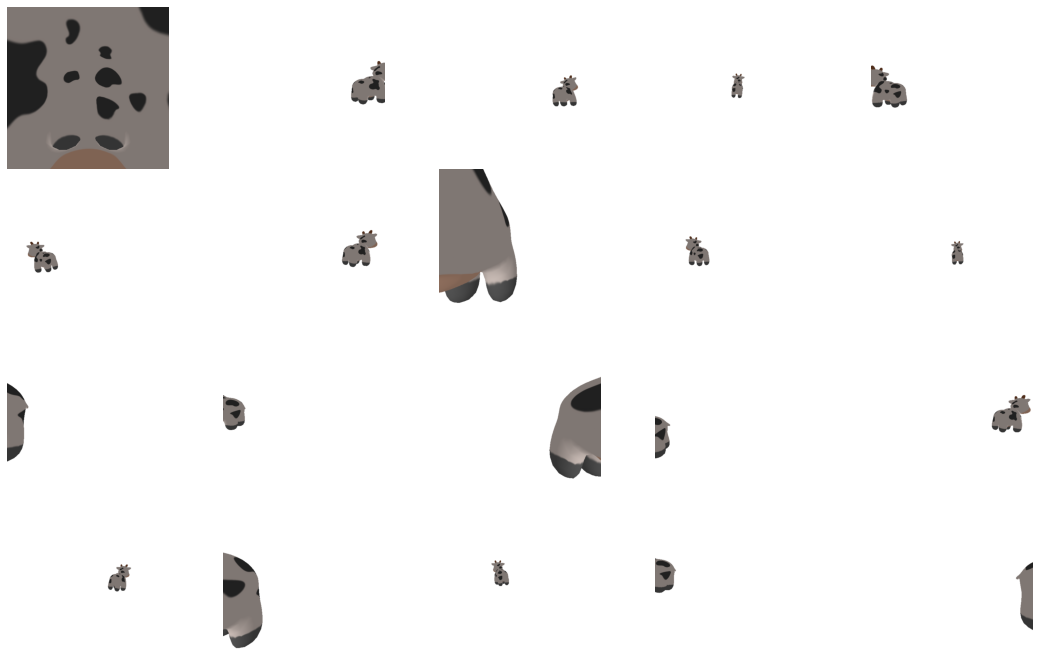

In [ ]:
import matplotlib.pyplot as plt
from pytorch3d.renderer import Textures
from pytorch3d.renderer import SfMPerspectiveCameras

def render_scene(meshes, cameras, device):
  """
  Renders 3D meshes to a tensor of images.

  Args:
    meshes: a Meshes instance holding the meshes to be rendered
    cameras: a pytorch3D Cameras instance such as PerspectiveCameras
    device: a torch.device

  """
  if len(meshes) != len(cameras):
    meshes = meshes.extend(len(cameras))

  raster_settings = RasterizationSettings(
      image_size=512, 
      blur_radius=0.0, 
      faces_per_pixel=1, 
  )
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
  renderer = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=cameras, 
          raster_settings=raster_settings
      ),
      shader=SoftPhongShader(
          device=device, 
          cameras=cameras,
          lights=lights
      )
  )
  return renderer(meshes).detach()

# build ground truth cameras
gt_sfm_cameras = SfMPerspectiveCameras(device=device, R=R_absolute_gt, T=T_absolute_gt)

# you can visualize the images using the image_grid function:
images = render_scene(cow_mesh_batch, gt_sfm_cameras, device)
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

# or you can choose a single image to check with matplotlib
# plt.figure(figsize=(10, 10))
# plt.imshow(images[0, ..., :3].cpu().numpy())
# plt.grid("off");
# plt.axis("off");

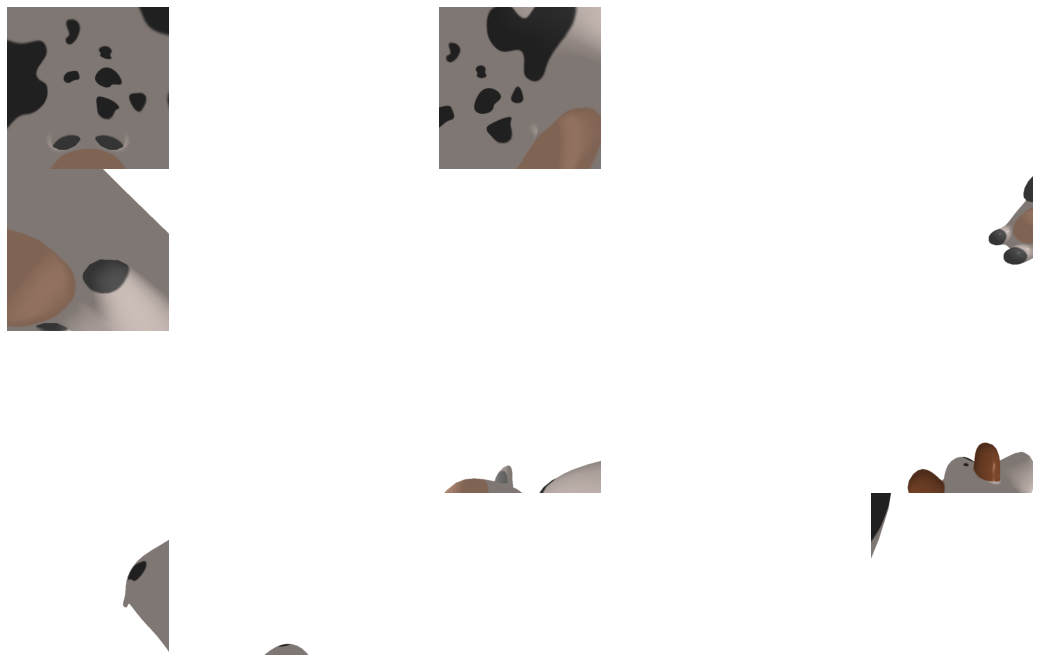

In [ ]:
#3.1. Download the cow mesh and user the function render_scene (below) to render it using the cameras of the ground truth. Do the same using the initial values of the estimated cameras.

init_sfm_cameras = SfMPerspectiveCameras(device=device, R=so3_exponential_map(log_R_absolute_init), T=T_absolute_init)

images = render_scene(cow_mesh_batch, init_sfm_cameras, device)
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

3.2 Run the optimization loop and plot the  *loss vs iteration* graph. 

**[Extra] E.1: Can you do better (improve the approximation)?**

Uma das coisas que podem ser feitas é melhorar a inicialização das câmeras. Assim como foi discutido na segunda parte do trabalho. Também pode ser utilizada uma outra representação.

3.3 Render the images again, now using the ground truth cameras and the optimized cameras. Describe the results qualitatively.

Como foi visto, os resultados ficaram semelhantes, mas uma leve diferente no render, visto que o erro ainda teve uma diferença.

**[Extra] E.2: Use another representation for rotation matrices to solve the bundle adjustment problem.**

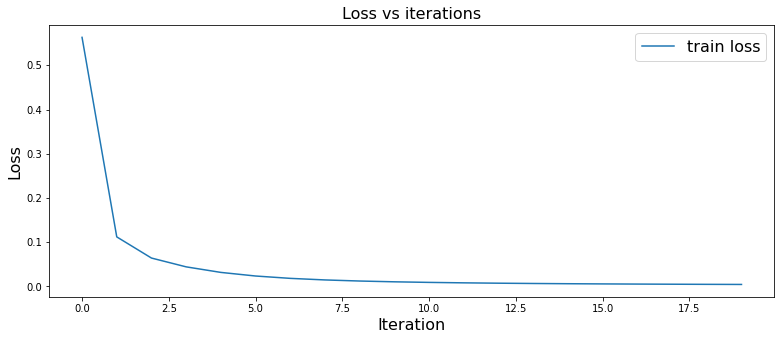

In [ ]:
# 3.2 Run the optimization loop and plot the loss vs iteration graph.

def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");
plot_losses(losses)

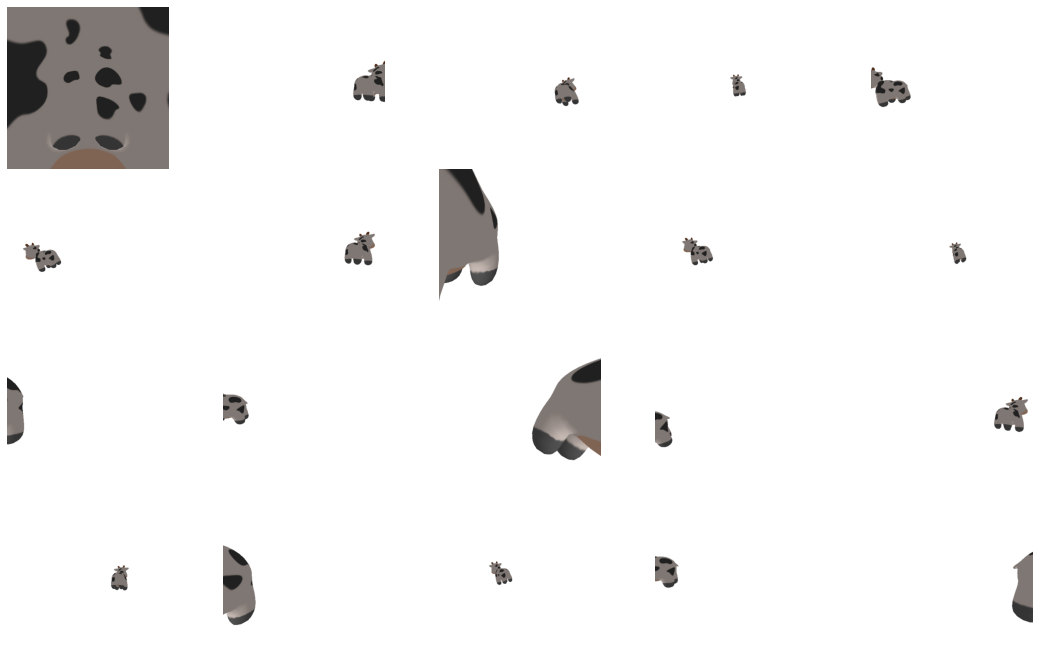

In [ ]:
# 3.3 Render the images again, now using the ground truth cameras and the optimized cameras.
#  Describe the results qualitatively.

approx_sfm_cameras = SfMPerspectiveCameras(device=device, R=so3_exponential_map(log_R_absolute), T=T_absolute)

images = render_scene(cow_mesh_batch, approx_sfm_cameras, device)
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

In [ ]:
#https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/transforms/so3.html
#https://pytorch3d.readthedocs.io/en/latest/modules/transforms.html
#https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/transforms/rotation_conversions.html
#https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/transforms/transform3d.html

#[Extra] E.1: Can you do better (improve the approximation)?
  # improve the initial guess is important! Even a simple modification like making
  #   all initial guesses equals to [0,0,0]
#[Extra] E.2: Use another representation for rotation matrices to solve the bundle adjustment problem.

In [ ]:
#[Extra] E.1: Can you do better (improve the approximation)?

def run_bundle_adjustment_optimization(initial_guess, get_relative_cam, calc_camera_dist):
  # initialize the absolute log-rotations/translations with random entries
  log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
  T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

  # furthermore, we know that the first camera is a trivial one 
  # (check exercise 1.1 above)
  if initial_guess == 0:
    log_R_absolute_init[0, :] = 0.
    T_absolute_init[0, :] = 0.
  ########### for Extra E.1
  elif initial_guess == 1:
    log_R_absolute_init[:,:] = 0.
    T_absolute_init[:,:] = 0.

  # instantiate a copy of the initialization of log_R / T
  log_R_absolute = log_R_absolute_init.clone().detach()
  log_R_absolute.requires_grad = True
  T_absolute = T_absolute_init.clone().detach()
  T_absolute.requires_grad = True

  # the mask the specifies which cameras are going to be optimized
  #     (since we know the first camera is already correct, 
  #      we only optimize over the 2nd-to-last cameras)
  camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
  camera_mask[0] = 0.

  # init the optimizer
  optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.1, momentum=0.9)

  losses = {"train loss": []}

  # run the optimization
  n_iter = 2000  # fix the number of iterations
  for it in range(n_iter):
      # re-init the optimizer gradients
      optimizer.zero_grad()

      # compute the absolute camera rotations as 
      # an exponential map of the logarithms (=axis-angles)
      # of the absolute rotations
      R_absolute = so3_exponential_map(log_R_absolute * camera_mask)

      # get the current absolute cameras
      cameras_absolute = PerspectiveCameras(
          R = R_absolute,
          T = T_absolute * camera_mask,
          device = device,
      )

      # compute the relative cameras as a compositon of the absolute cameras
      cameras_relative_composed = \
          get_relative_cam(cameras_absolute, relative_edges)

      # compare the composed cameras with the ground truth relative cameras
      # camera_distance corresponds to $d$ from the description
      camera_distance = \
          calc_camera_dist(cameras_relative_composed, cameras_relative)

      # our loss function is the camera_distance
      camera_distance.backward()
      
      # apply the gradients
      optimizer.step()

      # plot and print status message
      if (it % 100==0 or it==n_iter-1) and it != 0:
          status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
          print(status)
          #plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)
          losses["train loss"].append(camera_distance)
      if it==n_iter-1:
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, "Finished")
  print('Optimization finished.')

  return { "loss": losses,
           "log_R": log_R_absolute,
           "T": T_absolute,
          }

iteration=100; camera_distance=9.321e-01
iteration=200; camera_distance=2.408e-01
iteration=300; camera_distance=2.004e-01
iteration=400; camera_distance=1.940e-01
iteration=500; camera_distance=1.887e-01
iteration=600; camera_distance=1.800e-01
iteration=700; camera_distance=1.661e-01
iteration=800; camera_distance=1.456e-01
iteration=900; camera_distance=1.189e-01
iteration=1000; camera_distance=8.896e-02
iteration=1100; camera_distance=6.082e-02
iteration=1200; camera_distance=3.894e-02
iteration=1300; camera_distance=2.461e-02
iteration=1400; camera_distance=1.620e-02
iteration=1500; camera_distance=1.145e-02
iteration=1600; camera_distance=8.678e-03
iteration=1700; camera_distance=6.962e-03
iteration=1800; camera_distance=5.824e-03
iteration=1900; camera_distance=5.018e-03
iteration=1999; camera_distance=4.418e-03


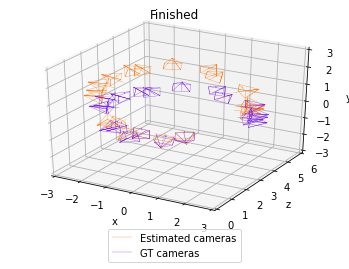

Optimization finished.


In [ ]:
t0 = run_bundle_adjustment_optimization(0, get_relative_camera, calc_camera_distance)

iteration=100; camera_distance=9.518e-01
iteration=200; camera_distance=5.389e-02
iteration=300; camera_distance=4.604e-03
iteration=400; camera_distance=1.051e-03
iteration=500; camera_distance=3.720e-04
iteration=600; camera_distance=1.517e-04
iteration=700; camera_distance=6.594e-05
iteration=800; camera_distance=2.987e-05
iteration=900; camera_distance=1.387e-05
iteration=1000; camera_distance=6.647e-06
iteration=1100; camera_distance=3.273e-06
iteration=1200; camera_distance=1.626e-06
iteration=1300; camera_distance=8.477e-07
iteration=1400; camera_distance=4.424e-07
iteration=1500; camera_distance=2.469e-07
iteration=1600; camera_distance=1.583e-07
iteration=1700; camera_distance=7.601e-08
iteration=1800; camera_distance=6.593e-08
iteration=1900; camera_distance=9.979e-08
iteration=1999; camera_distance=7.092e-08


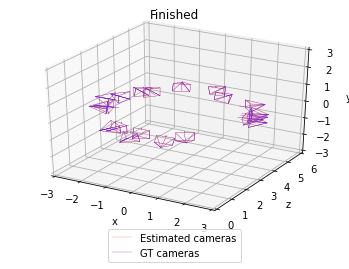

Optimization finished.


In [ ]:
t1 = run_bundle_adjustment_optimization(1, get_relative_camera, calc_camera_distance)

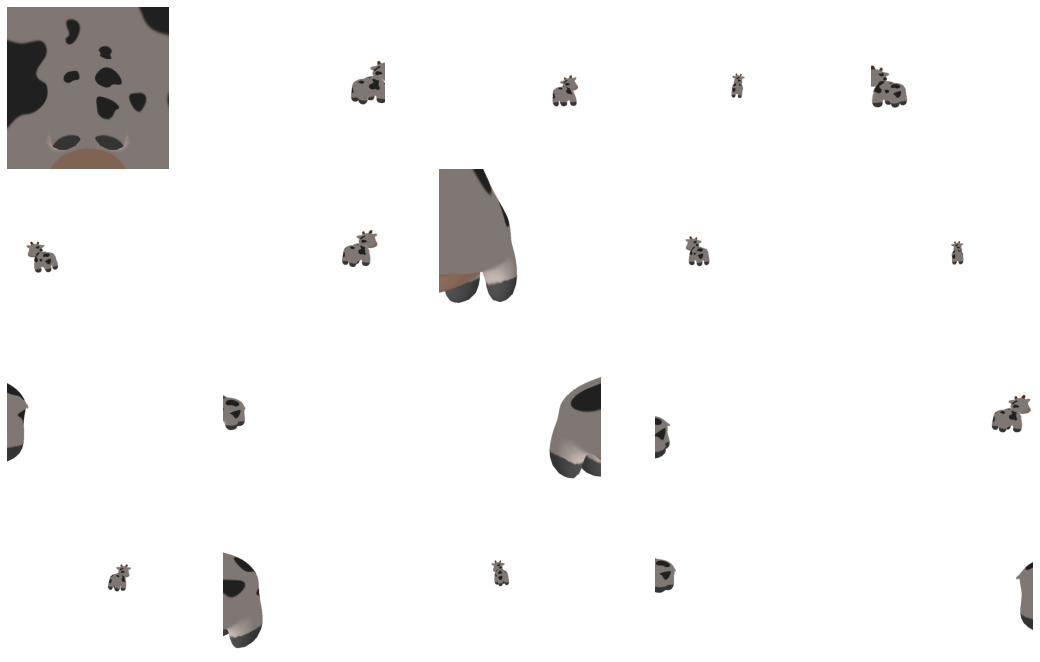

In [ ]:
better_sfm_cameras = SfMPerspectiveCameras(device=device, R=so3_exponential_map(t1["log_R"]), T=t1["T"])

images = render_scene(cow_mesh_batch, better_sfm_cameras, device)
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

iteration=100; camera_distance=1.068e+00
iteration=200; camera_distance=6.166e-02
iteration=300; camera_distance=5.839e-03
iteration=400; camera_distance=1.480e-03
iteration=500; camera_distance=5.100e-04
iteration=600; camera_distance=1.873e-04
iteration=700; camera_distance=6.978e-05
iteration=800; camera_distance=2.610e-05
iteration=900; camera_distance=9.791e-06
iteration=1000; camera_distance=3.689e-06
iteration=1100; camera_distance=1.407e-06
iteration=1200; camera_distance=5.576e-07
iteration=1300; camera_distance=2.394e-07
iteration=1400; camera_distance=1.236e-07
iteration=1500; camera_distance=7.552e-08
iteration=1600; camera_distance=5.719e-08
iteration=1700; camera_distance=5.588e-08
iteration=1800; camera_distance=5.900e-08
iteration=1900; camera_distance=5.209e-08
iteration=1999; camera_distance=4.957e-08


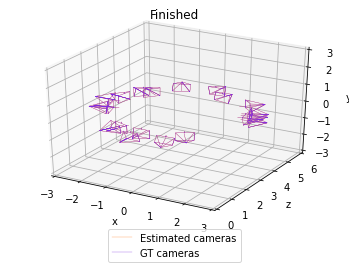

Optimization finished.


In [27]:
#[Extra] E.2: Use another representation for rotation matrices to solve the bundle adjustment problem.
#Using quaternions for partial computation

from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,   
)
from pytorch3d.transforms import (
    axis_angle_to_quaternion,
    quaternion_to_matrix,
    quaternion_invert,
    quaternion_multiply,
    standardize_quaternion,
    matrix_to_quaternion
)

import numpy as np
from numpy import linalg as LA

def quat_calc_camera_distance(cam_1, cam_2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between 
    the rotation components of the camera extrinsics and the L2 distance
    between the translation vectors.
    """
    #q1 = matrix_to_quaternion(cam_1.R)
    #q2 = matrix_to_quaternion(cam_2.R)
    # rotation distance
    R_distance = (1.-so3_relative_angle(cam_1.R, cam_2.R, cos_angle=True)).mean()
    #R_distance = ((cam_1.R - cam_2.R)**2).sum(1).mean()
    #R_distance = 0.0
    #q1n = q1
    #q2n = q2
    #R_distance = (1.0 - (q1n*quaternion_invert(q2n))[:,0]).mean()
    
    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance

    #quaternion_to_axis_angle

def quat_get_relative_camera(edges, Q, T):
    """
    For each pair of indices (i,j) in "edges" generate a camera
    that maps from the coordinates of the camera cams[i] to 
    the coordinates of the camera cams[j]
    """
    Qtrans_rel = quaternion_multiply(quaternion_invert(Q[edges[:, 0]]), Q[edges[:, 1]])
    Ttrans_sub = (T[edges[:, 1]] - T[edges[:, 0]])
    Ttrans_mat = quaternion_to_matrix(Q[edges[:, 0]]).inverse()
    Ttrans_rel = torch.bmm(Ttrans_mat, Ttrans_sub.view(-1, 3, 1))
    Ttrans_rel = Ttrans_rel.view(-1, 3)

    # first generate the world-to-view Transform3d objects of each 
    # camera pair (i, j) according to the edges argument
    trans_i, trans_j = [
        PerspectiveCameras(
            R = quaternion_to_matrix(Q[edges[:, i]]),
            T = T[edges[:, i]],
            device = device,
        ).get_world_to_view_transform()
         for i in (0, 1)
    ]
    

    # compose the relative transformation as g_i^{-1} g_j
    trans_rel = trans_i.inverse().compose(trans_j)
    
    ## generate a camera from the relative transform
    matrix_rel = trans_rel.get_matrix()
    cams_relative = PerspectiveCameras(
                        #R = matrix_rel[:, :3, :3],
                        R = quaternion_to_matrix(Qtrans_rel),
                        #T = Ttrans_rel,
                        T = matrix_rel[:, 3, :3],
                        device = device,
                    )
    return cams_relative

# initialize the absolute log-rotations/translations with random entries
R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# transform the rotations to quaternions
R_absolute_init = axis_angle_to_quaternion(R_absolute_init)

# set the first rotation as identity
R_absolute_init[:,:] = torch.tensor([1.0, 0.0, 0.0, 0.0])
T_absolute_init[:,:] = 0.0

# instantiate a copy of the initialization of log_R / T
R_absolute = R_absolute_init.clone().detach()
R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct, 
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([R_absolute, T_absolute], lr=.1, momentum=0.9)

quat_losses = {"train loss": []}

# run the optimization
n_iter = 2000  # fix the number of iterations
for it in range(n_iter):
  # re-init the optimizer gradients
  optimizer.zero_grad()

  ## build rotation matrices 
  #list_rotations = quaternion_to_matrix(R_absolute)
  ## camera_mask [0, 1, 1, 1, ...]
  #list_rotations[0] = quaternion_to_matrix(torch.tensor([1.0,0.0,0.0,0.0]))

  list_qrotations = standardize_quaternion(R_absolute)
  list_qrotations[0] = axis_angle_to_quaternion(torch.tensor([0.0,0.0,0.0]))

  ## get the current absolute cameras
  #cameras_absolute = PerspectiveCameras(
  #  R = list_rotations,
  #  T = T_absolute * camera_mask,
  #  device = device,
  #)

  # compute the relative cameras as a compositon of the absolute cameras
  cameras_relative_composed = \
    quat_get_relative_camera(relative_edges, list_qrotations, T_absolute * camera_mask)

  # compare the composed cameras with the ground truth relative cameras
  # camera_distance corresponds to $d$ from the description
  camera_distance = \
    quat_calc_camera_distance(cameras_relative_composed, cameras_relative)

  # our loss function is the camera_distance
  camera_distance.backward()
      
  # apply the gradients
  optimizer.step()

  # plot and print status message
  if (it % 100==0 or it==n_iter-1) and it != 0:
    status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
    print(status)
#          #plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)
    quat_losses["train loss"].append(camera_distance)
  if it==n_iter-1:
    cameras_quat = PerspectiveCameras(device=device, R=quaternion_to_matrix(R_absolute), T=T_absolute)
    plot_camera_scene(cameras_quat, cameras_absolute_gt, "Finished")
    print('Optimization finished.')
#
#  return { "loss": losses,
#           "log_R": log_R_absolute,
#           "T": T_absolute,
#          }

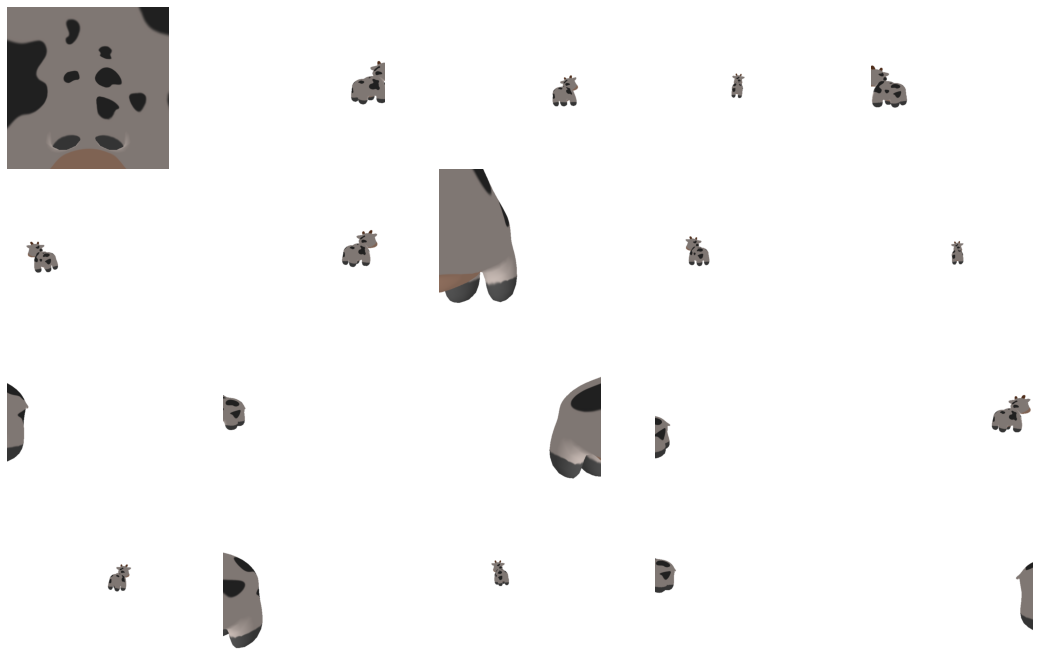

In [ ]:
qat_sfm_cameras = SfMPerspectiveCameras(device=device, R=quaternion_to_matrix(R_absolute), T=T_absolute)


images = render_scene(cow_mesh_batch, qat_sfm_cameras, device)
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0')
iteration=100; camera_distance=2.924e+00
iteration=200; camera_distance=1.043e+00
iteration=300; camera_distance=7.891e-01
iteration=400; camera_distance=6.635e-01
iteration=500; camera_distance=4.784e-01
iteration=600; camera_distance=3.147e-01
iteration=700; camera_distance=2.369e-01
iteration=800; camera_distance=2.105e-01
iteration=900; camera_distance=2.026e-01
iteration=1000; camera_distance=2.003e-01
iteration=1100; camera_distance=1.996e-01
iteration=1200; camera_distance=1.994e-01
iteration=1300; camera_distance=1.993e-01
iteration=1400; camera_distance=1.992e-01
iteration=1500; camera_distance=1.991e-01
iteration=1600; camera_distance=1.991e-01
iteration=1700; camera_distance=1.990e-01
iteration=1800; camera_distance=1.989e-01
iteration=1900; camera_distance=1.988e-01
iteration=1999; camera_distance=1.988e-01


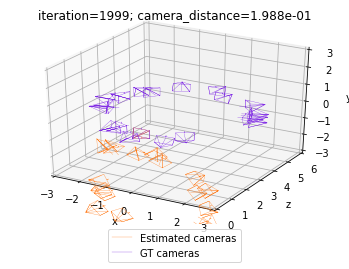

Optimization finished.


In [ ]:

def symmetric_orthogonalization(x):
  m = x.view(-1,3,3)
  u,s,v = torch.svd(m)
  vt = torch.transpose(v,1,2)
  det = torch.det(torch.matmul(u,vt))
  det = det.view(-1,1,1)
  vt = torch.cat((vt[:,:2,:], vt[:,-1:,:] * det), 1)
  r = torch.matmul(u, vt)
  return r

  # initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 9, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one 
# (check exercise 1.1 above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct, 
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.1, momentum=0.9)

svd_losses = {"train loss": []}

# run the optimization
n_iter = 2000  # fix the number of iterations
for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as 
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = symmetric_orthogonalization(log_R_absolute * camera_mask)

    # get the current absolute cameras
    cameras_absolute = PerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # our loss function is the camera_distance
    camera_distance.backward()
    
    # apply the gradients
    optimizer.step()

    # plot and print status message
    if (it % 100==0 or it==n_iter-1) and it != 0:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        print(status)
        svd_losses["train loss"].append(camera_distance)
    if it==n_iter-1:
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

print('Optimization finished.')

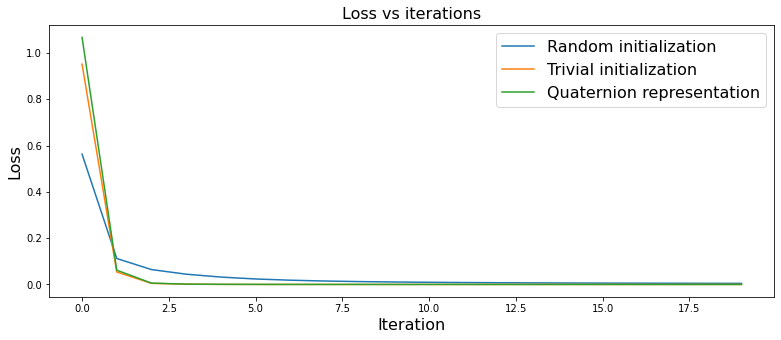

In [ ]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");
batch_loss = {}
batch_loss["Random initialization"] = losses["train loss"]
batch_loss["Trivial initialization"] = t1["loss"]["train loss"]
batch_loss["Quaternion representation"] = quat_losses["train loss"]
#batch_loss["SVD"] = svd_losses["train loss"]
plot_losses(batch_loss)

Referências:

https://www.youtube.com/watch?v=WX9Q7JC78lI&ab_channel=nptelhrd

https://www.youtube.com/watch?v=Hwow9hcPi28&ab_channel=nptelhrd

https://www.youtube.com/watch?v=-TUTqVOGSa8&ab_channel=nptelhrd

https://www.youtube.com/watch?v=5YJwszR246I&ab_channel=nptelhrd

https://www.youtube.com/watch?v=wbaCbsfd7z0&ab_channel=nptelhrd

https://rock-learning.github.io/pytransform3d/rotations.html

https://www.cs.utexas.edu/~huangqx/CS354_Lecture_20.pdf

https://www.cs.ubc.ca/~tmm/courses/cpsc414-03-fall/Vsep2003/slides/week9.wed.slides.pdf

https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation#Comparison_with_other_representations_of_rotations

https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation#Advantages_of_quaternions

https://ingmec.ual.es/~jlblanco/papers/jlblanco2010geometry3D_techrep.pdf
